# Country music lyrics analysis
## Contents
- [Word frequencies](#How-often-does-each-artist-mention-a-given-term?)
- [Word usage correlations](#Word-usage-correlations)
- [Values over time](#Measure-values-over-time)
- [NLTK](#NLTK)
- [scikit-learn](#scikit-learn)
- [Word clouds](#Word-clouds)
- [Dimensionality reduction](#Dimensionality-reduction)

---

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nltk
from nltk.classify import apply_features
from nltk import word_tokenize
import random
import time
import re
from datetime import datetime
fs = 16 # fontsize

## Scrape artists and lyrics
Use the ```downloadLyrics.py``` file for this

## Load and format the lyrics JSON object

In [2]:
# Load the artist lyrics
artists = json.load(open('lyrics/country_lyrics.json'))['artists']

In [3]:
# Use a generator to exclude artists with too few songs
def filterBySongCount(artists, min_count=10, max_count=10000):
    for artist in artists:        
        num_songs = len(artist['songs'])
        if (num_songs >= min_count) and (num_songs < max_count): yield artist

min_songs, max_songs = 20, 5000
artists = list(filterBySongCount(artists, min_songs, max_songs))

# Gender
labels_gender = np.array([a['gender'] for a in artists])
mask_female = np.array([g=='female' for g in labels_gender])
mask_male   = np.array([g=='male'   for g in labels_gender])
print("You have lyrics from {} artists, with a minimum of {} songs per artist.\nFemale: {}, male: {}"
      .format(len(artists), min_songs, (labels_gender=='female').sum(), (labels_gender=='male').sum()))

# Add all song lyrics to a single list
all_songs = []
for artist, gender in zip(artists, labels_gender):
    for song in artist['songs']:        
        song['gender'] = gender
        all_songs.append(song)        
        
song_count = len(all_songs)
print("Database contains {} songs.".format(song_count))

# Store all lyrics in a single string
all_lyrics = " ".join([song['lyrics'] for song in all_songs])

You have lyrics from 78 artists, with a minimum of 20 songs per artist.
Female: 37, male: 41
Database contains 12375 songs.


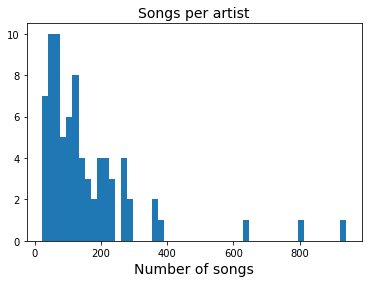

In [4]:
# How many songs do we typically have for each artist?
songs_per_artist = np.array([len(a['songs']) for a in artists])
plt.hist(songs_per_artist,50)
plt.xlabel("Number of songs", fontsize=14)
plt.title("Songs per artist", fontsize=14)
plt.show()

---
# Textual analysis
### [⇧](#Country-music-lyrics-analysis)

### Words per song

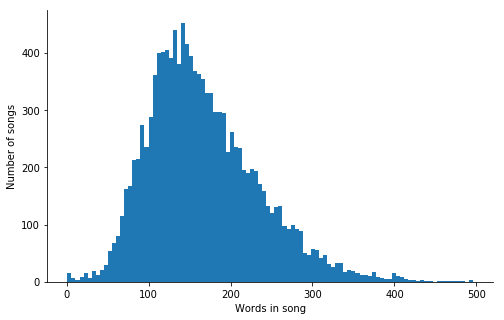

In [5]:
# Words per song
word_counts = [len(song['lyrics'].split(' ')) for song in all_songs]
word_counts = list(filter(lambda x: x<500, word_counts))

fig, axs = plt.subplots(figsize=(8,5))
axs.hist(word_counts,100)
axs.set_xlabel("Words in song")
axs.set_ylabel("Number of songs")
# Hide the right and top spines
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
plt.show()

## How often does each artist mention a given term?
### [⇧](#Country-music-lyrics-analysis)

In [29]:
# TODO: Clean these up. Combine them? Do I want to be using a DataFrame like I am?
def calcFreqOfTerm(artist, terms):    
    # Determine how many songs mention a given term
    songs = artist['songs']
    song_count, term_count = len(songs), 0
    for song in songs:
        for term in terms:            
            if term.lower() in song['lyrics'].lower():
                term_count += 1
                break

    term_freq = round(term_count/float(song_count),5)    
    data = np.reshape([term_freq, term_count, song_count],(1,3))
    return pd.DataFrame(data, columns=['frequency','count','total'], index=[artist['artist']])

def calcTermFreqAcrossArtists(artists, terms):
    if not isinstance(terms, list):
        terms = [terms]

    term_freqs = pd.concat([calcFreqOfTerm(artist, terms) for artist in artists],axis=0)
    term_freqs.term = "_OR_".join(terms)
    return term_freqs

#### Bar graphs for term frequency

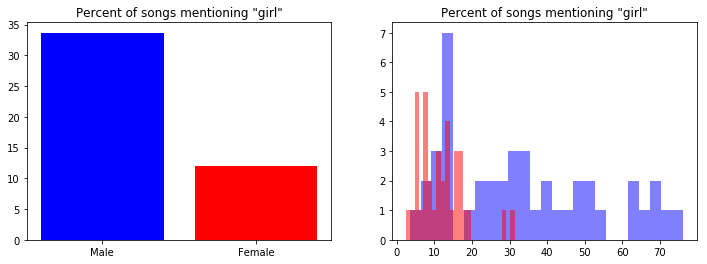

In [37]:
# Get the frequency (mentions/total songs) of a given term for each artist
freqs = calcTermFreqAcrossArtists(artists, 'girl')
freqs_male   = 100*freqs['frequency'].values[mask_male]
freqs_female = 100*freqs['frequency'].values[mask_female]

# Bar graph
fig, axs = plt.subplots(ncols=2,figsize=(12,4))
axs[0].bar(0,freqs_male.mean(),color='b')#,yerr=freqs_male.std())
axs[0].bar(1,freqs_female.mean(),color='r')#,yerr=freqs_female.std())
axs[0].set_title("Percent of songs mentioning \"{}\"".format(freqs.term))
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(("Male","Female"))

# Histogram
axs[1].hist(freqs_male,25,color='b',alpha=0.5)
axs[1].hist(freqs_female,25,color='r',alpha=0.5)
axs[1].set_title("Percent of songs mentioning \"{}\"".format(freqs.term))
plt.show()

#### Bar graphs for multiple terms

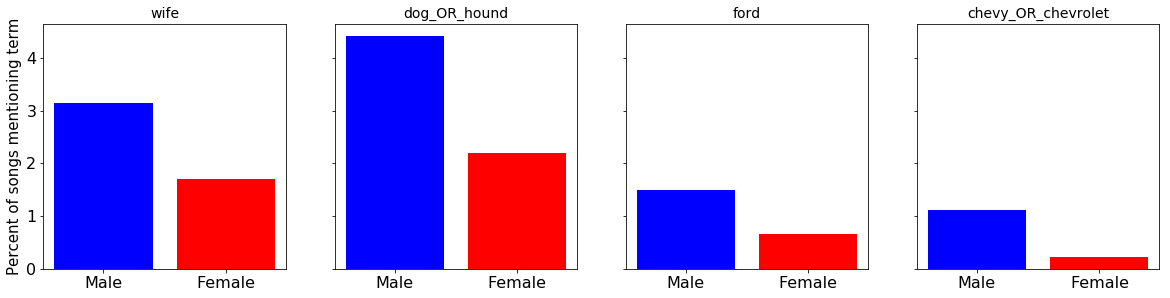

In [27]:
# terms = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# terms = most_common[:10]
# terms = most_common[10:20]
terms = ["wife",["dog",'hound'],"ford",["chevy",'chevrolet']]
fig, axs = plt.subplots(ncols=len(terms), sharey=True, figsize=(20,4.5))
fs = 16
for term, ax in zip(terms,axs):
    # Get the frequency (mentions/total songs) of a given term for each artist
    freqs = calcTermFreqAcrossArtists(artists, term)
    freqs_male   = 100*freqs['frequency'].values[mask_male]
    freqs_female = 100*freqs['frequency'].values[mask_female]

    # Bar graph    
    ax.bar(0,freqs_male.mean(),color='b')
    ax.bar(1,freqs_female.mean(),color='r')
    ax.set_xticks([0,1])
    ax.set_xticklabels(("Male","Female"), fontsize=fs)
    ax.set_title('{}'.format(freqs.term), fontsize=fs-2)
    ax.tick_params(labelsize=fs)
    if term == terms[0]:
        ax.set_ylabel("Percent of songs mentioning term", fontsize=fs-1)       
    
# plt.savefig('./figures/BarGraph_Weekend.png',bbox_inches='tight')
plt.show()

## Word usage correlations
### [⇧](#Country-music-lyrics-analysis)

In [15]:
def fitLine(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    soln = np.linalg.lstsq(A, y, rcond=None)[0]    
    
    # residual sum of squares
    y_fit = soln[0]*x + soln[1]
    ss_res = np.sum((y - y_fit)**2) # residuals ?
    ss_tot = np.sum((y - y.mean())**2) # total sum of squares
    r2 = round(1 - (ss_res / ss_tot), 3) # r-squared
        
    return y_fit, x, r2

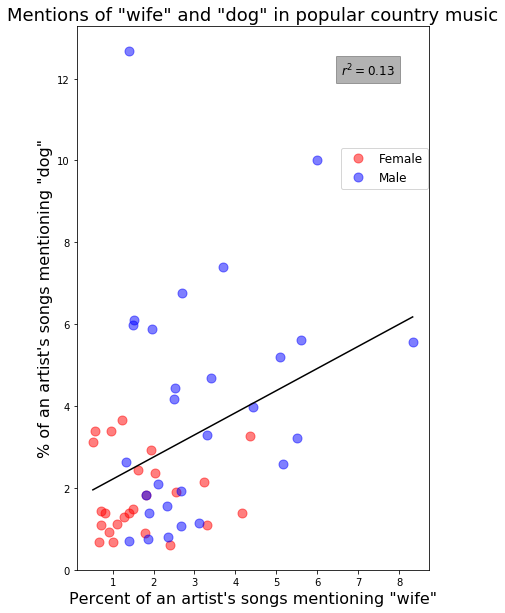

In [18]:
# Calculate two frequency variables
f1 = calcTermFreqAcrossArtists(artists, 'wife')
f2 = calcTermFreqAcrossArtists(artists, 'dog')
x, y = 100*f1['frequency'].values, 100*f2['frequency'].values

# Mask the data by gender
include_zeros = 0
if include_zeros:
    mask_not_zero = np.array([True] * len(x))
else:    
    mask_not_zero = (x > 0) * (y > 0)
mask_male   = [artist['gender']=='male'   for artist in artists] * mask_not_zero
mask_female = [artist['gender']=='female' for artist in artists] * mask_not_zero

# Scatter plot the data
ms = 9
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x[mask_female], y[mask_female], 'ro', markersize=ms, alpha=0.5)
ax.plot(x[mask_male],   y[mask_male],   'bo', markersize=ms, alpha=0.5)

# Fit lines to the two classes
LR, UD = 0.75, 1.05
for mask, c, pos in zip([mask_female, mask_male, mask_not_zero],['r','b','k'],[(LR,UD),(LR,UD-0.07),(LR,UD-0.14)]):
    y_fit, t, r2 = fitLine(x[mask], y[mask])

    # Plot the fitted lines
    i,j = np.argmin(t), np.argmax(t)
    if c is 'k':
        ax.plot(t[[i,j]], y_fit[[i,j]], c)                    
        ax.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=fs-4,
                bbox={'facecolor':c, 'alpha':0.3, 'pad':5}, xycoords='axes fraction',  xy=pos),
                
# add text to the plot
ax.set_xlabel('Percent of an artist\'s songs mentioning "{}"'.format(f1.term),fontsize=fs)
ax.set_ylabel('% of an artist\'s songs mentioning "{}"'.format(f2.term),fontsize=fs);
ax.set_title('Mentions of "{}" and "{}" in popular country music'.format(f1.term, f2.term), fontsize=fs+2)
ax.set_aspect('equal')
ax.legend(['Female','Male'],loc=(0.75, 0.7),fontsize=fs-4);

# Add an arrow
ap = dict(facecolor='black', shrink=0.15, headlength=8)
xy = (np.max(x), y[np.argmax(x)])
xy_t = (x[np.argmax(y)], np.max(y))
# ax.annotate("", xy=xy, xytext=(.98*xy[0],1.2*xy[1]), arrowprops=ap)
# ax.annotate("Cole Swindell,\nagain", xy=xy, xytext=(.96*xy[0],1.2*xy[1]),
#                       horizontalalignment='center', fontsize=fs-4)
# ax.annotate("", xy=xy_t, xytext=(2*xy_t[0],0.95*xy_t[1]), arrowprops=ap)
# ax.annotate("Dottie West,\nloves love", xy=xy_t, xytext=(2.3*xy_t[0],0.9*xy_t[1]),
#                       horizontalalignment='center', fontsize=fs-4)
# plt.savefig('./figures/FreqPlot_{}_and_{}.png'.format(f1.term,f2.term),bbox_inches='tight',dpi=300)
plt.show()

In [20]:
print(artists[np.argmax(x)]['artist'])
print(artists[np.argmax(x)]['songs'][0]['image'])
print(artists[np.argmax(y)]['artist'])
print(artists[np.argmax(y)]['songs'][0]['image'])

Cole Swindell
https://images.genius.com/6fdc763c5e3fc9d943d4b655cdd94af3.250x250x1.jpg
Dottie West
https://images.genius.com/a395bc702cb390a038aaf81479d21a93.290x259x1.jpg


#### Notes
It really should be an automated process to find the features that best split on gender.

Pipeline:
  1. Get list of unique terms by frequency using NLTK
  2. The top 50 from that list of terms will be my feature space
  3. Find the combination of terms that maximizes distance between the two classes
  
  
#### Ideas
  - From a single song's lyrics, can I predict the artist gender?
    - Each song is labeled with a gender. So, once I have some decent features, I should be able to train a classifier. Pretty straight forward.

## Measure values over time
### [⇧](#Country-music-lyrics-analysis)

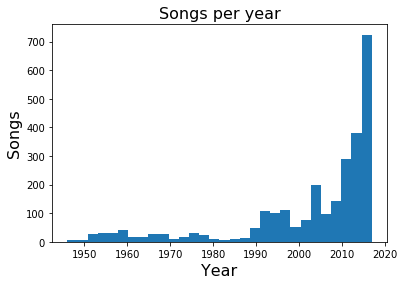

In [6]:
# TODO: make this not stupid.
songs_with_year = []
for song in filter(lambda s: s['year'] is not None, all_songs):
    d = datetime.strptime(song['year'], '%Y-%M-%d')
    if (d.year>=1900 and d.year<2018): # kludge for correct parsing of date
#     if (d.year>=2002 and d.year<2018): # kludge for correct parsing of date        
        song['date'] = d
        songs_with_year.append(song)

# Kludge to sort the songs by year
years = np.array(list(map(lambda d: d.year, [s['date'] for s in songs_with_year])))
songs_with_year = np.array([x for _, x in sorted(zip(years, songs_with_year), key=lambda pair: pair[0])])
years.sort()

# Distribution of the years
plt.hist(years, 30)
plt.xlabel("Year", fontsize=fs)
plt.ylabel("Songs", fontsize=fs)
plt.title("Songs per year",fontsize=fs)
plt.show()

### Vocabulary size and diversity

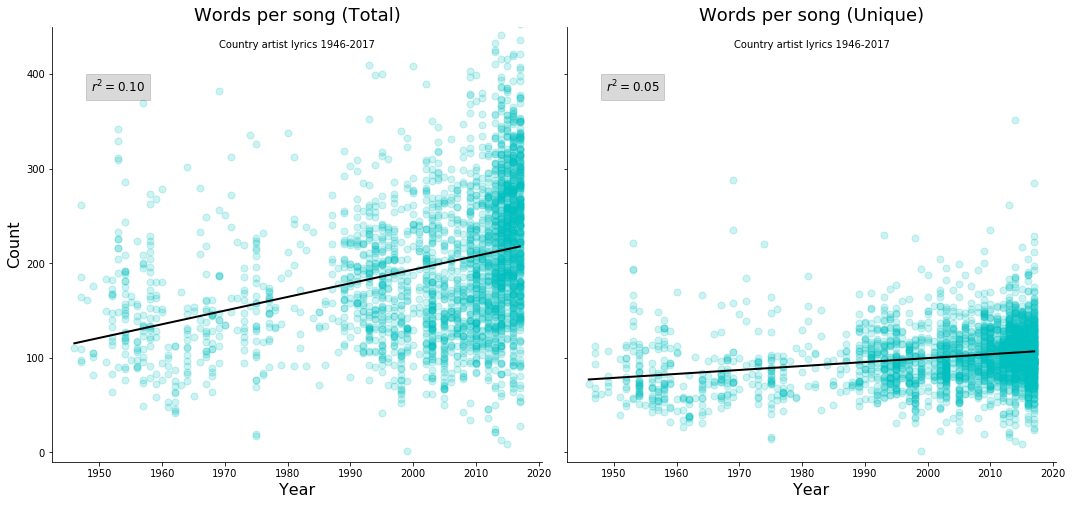

In [9]:
# http://kaylinwalker.com/50-years-of-pop-music/
# Words per song
word_counts = [len(song['lyrics'].split(' ')) for song in songs_with_year]
word_counts_unique = [len(set(song['lyrics'].split(' '))) for song in songs_with_year]

plt.figure(figsize=(18,8))
gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.05)

for i, counts, title in zip(range(2),[word_counts, word_counts_unique],["Total", "Unique"]):
    ax = plt.subplot(gs1[i])
    
    y_fit, t, r2 = fitLine(years, np.array(counts))
    ax.plot(years, counts, 'co', alpha=0.2, markersize=7)
    ax.plot(t, y_fit, 'k', linewidth=2)
    ax.set_xlabel("Year", fontsize=fs)    
    ax.set_title("Words per song ({})".format(title), fontsize=fs+2)
    if i == 0:
        ax.set_ylabel("Count", fontsize=fs)
    else:
        ax.set_yticklabels([])
        
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=fs-4,
        bbox={'facecolor':'black', 'alpha':0.15, 'pad':5}, xycoords='axes fraction', xy=(0.08, 0.85)),        
    ax.text(0.5, 0.96, 'Country artist lyrics {}-{}'.format(min(years),max(years)),
            transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')
    ax.set_ylim([-10, 450])
    
# plt.savefig('./figures/TimePlot_words_per_song.png', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
# Kludge method for calculating mean ratio for each year
ratios = {}
for yr, wcr in zip(years, word_count_ratio):
    if yr in ratios:
        ratios[yr].append(wcr)
    else:
        ratios[yr] = [wcr]

averages = []        
sigs = []
for yr in ratios:
    ratios[yr] = np.array(ratios[yr])
    averages.append(ratios[yr].mean())
    sigs.append(ratios[yr].std())

averages = np.array(averages)
sigs = np.array(sigs)

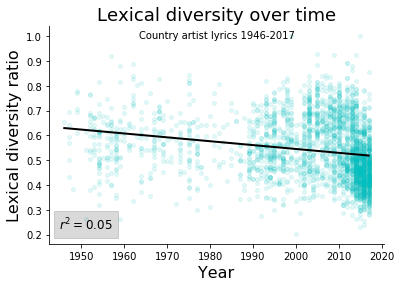

In [11]:
word_counts = [len(song['lyrics'].split(' ')) for song in songs_with_year]
word_count_ratio = [len(set(song['lyrics'].split(' ')))/float(wc) for song, wc in zip(songs_with_year, word_counts)]

fig, ax = plt.subplots(figsize=(6,4))
y_fit, t, r2 = fitLine(years, np.array(word_count_ratio))
ax.plot(years, word_count_ratio, 'co', alpha=0.1, markersize=4)
ax.plot(years, y_fit, 'k', linewidth=2)

# y_fit, t, _ = fitLine(np.array(list(ratios.keys())), averages)
# ax.errorbar(t, averages, yerr=sigs, fmt='rs')

ax.set_xlabel("Year", fontsize=fs)
ax.set_ylabel("Lexical diversity ratio", fontsize=fs)
ax.set_title("Lexical diversity over time", fontsize=fs+2)

ax.text(0.5, 0.96, 'Country artist lyrics {}-{}'.format(min(years),max(years)),
        transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')

ax.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=fs-4,
    bbox={'facecolor':'black', 'alpha':0.15, 'pad':5}, xycoords='axes fraction', xy=(0.03, 0.065)),

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig("figures/TimePlot_lexical_diversity.png", dpi=300)
plt.show()

### Popularity of a given term over time

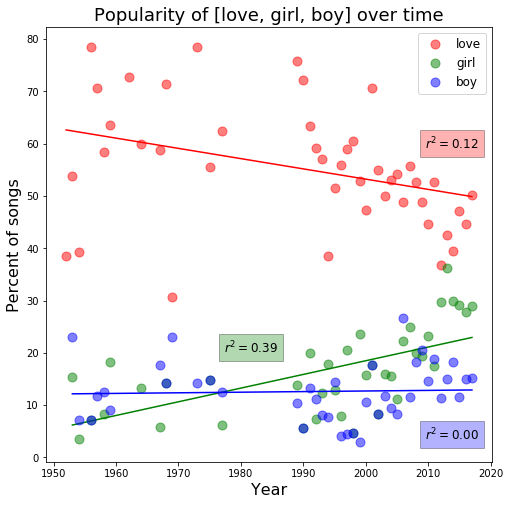

In [30]:
terms = ['love','girl','boy']
# terms = ['truck']

assert isinstance(terms, list), "terms must be of type list."
fig, axs = plt.subplots(figsize=(8,8)); colors = 'rgbcmy'; fs=16
dots = []
pos = [(0.85,0.72), (0.4,0.25), (0.85,0.05)]
for i,term in enumerate(terms):

    # Store mentions of the term in a dictionary with years as the key
    mentions = {}
    songs_per_year = {}
    for song in songs_with_year:
        year = song['date'].year

        if year in songs_per_year:        
            songs_per_year[year] += 1
        else:
            songs_per_year[year] = 1

        if term in song['lyrics']:
            if year in mentions:
                mentions[year] += 1
            else:
                mentions[year] = 1

    # Normalize the mention values
    min_songs = 10
    for year in list(mentions.keys()):
        if songs_per_year[year] > min_songs:
            mentions[year] = 100*mentions[year]/float(songs_per_year[year])
        else:
            mentions.pop(year)
                
    # Linear regression
    years, counts = np.array(list(mentions.keys())), np.array(list(mentions.values()))
    counts = [x for _, x in sorted(zip(years, counts), key=lambda pair: pair[0])]
    years.sort()    
    y_fit, t, r2 = fitLine(years, np.array(counts))

    # Plot the points and the regression        
    dots.append(
    axs.plot(years, counts, 'o', color=colors[i], markersize=9, alpha=0.5)[0])
    axs.plot(years, y_fit,  '-', color=colors[i])      
    
    axs.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=fs-4,
            bbox={'facecolor':colors[i], 'alpha':0.3, 'pad':5}, xycoords='axes fraction',  xy=pos[i])
    
axs.set_title('Popularity of [{}] over time'.format(', '.join(terms)),fontsize=fs+2)
axs.set_xlabel('Year',fontsize=fs)
axs.set_ylabel('Percent of songs',fontsize=fs)
axs.legend(dots,terms, fontsize=fs-4)
plt.savefig('./figures/TimePlot_{}.png'.format("_".join(terms)),bbox_inches='tight')
plt.show()

## NLTK
### [⇧](#Country-music-lyrics-analysis)

### Lexical diversity of all songs

In [65]:
all_word_counts = np.array([[len(song['lyrics'].split()), len(set(song['lyrics'].split()))] for song in all_songs if len(song['lyrics'].split())<1000])

In [23]:
mask_songs_male   = np.array([song['gender'] =='male'   for song in all_songs])
mask_songs_female = np.array([song['gender'] == 'female' for song in all_songs])

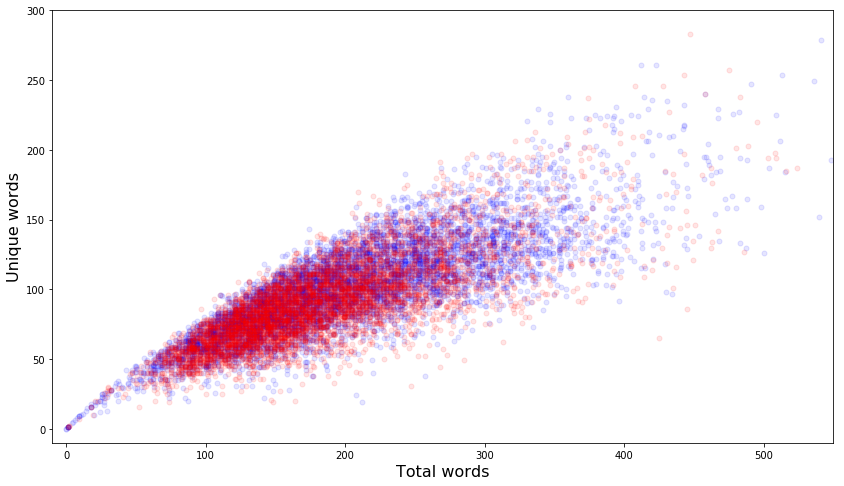

In [24]:
fig, ax = plt.subplots(figsize=(14,14))
ax.plot(all_word_counts[mask_songs_male,0],   all_word_counts[mask_songs_male,1],   'bo', alpha=0.1, markersize=5)
ax.plot(all_word_counts[mask_songs_female,0], all_word_counts[mask_songs_female,1], 'ro', alpha=0.1, markersize=5)
ax.set_aspect('equal')
ax.set_xlabel("Total words", fontsize=fs)
ax.set_ylabel("Unique words", fontsize=fs)
ax.set_xlim([-10, 550]); ax.set_ylim([-10, 300])
plt.show()

### Lexical diversity for each artist

In [11]:
def lexdiv(lyrics):
    try:
        return len(set(lyrics.split()))/float(len(lyrics.split()))
    except:
        return 0

In [12]:
lexical_diversity = np.zeros((len(artists),1))
for i, artist in enumerate(artists):    
    lexical_diversity[i] = np.mean([lexdiv(song['lyrics']) for song in artist['songs']])

In [13]:
min_lexdiv = artists[np.argmin(lexical_diversity)]['artist']
max_lexdiv = artists[np.argmax(lexical_diversity)]['artist']
print((min_lexdiv,max_lexdiv))

('Kane Brown', 'Kellie Pickler')


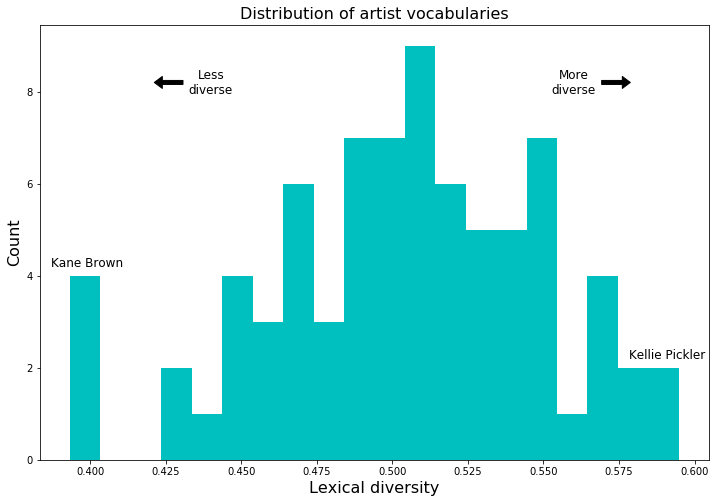

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(lexical_diversity,20,color='c')
ax.set_xlabel("Lexical diversity", fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.set_title("Distribution of artist vocabularies", fontsize=fs)

ap = dict(facecolor='black', shrink=0.1, headlength=8)
# ax.annotate("",xy=(0.398,4.05), xytext=(0.397,5), arrowprops=ap)
ax.annotate("{}".format(min_lexdiv), xy=(0.399,4.2),
           horizontalalignment='center', fontsize=fs-4)
# ax.annotate("",xy=(0.59,2.1), xytext=(0.589,3), arrowprops=ap)            
ax.annotate("{}".format(max_lexdiv), xy=(0.591,2.2),
           horizontalalignment='center', fontsize=fs-4)

ax.annotate("Less\ndiverse", xy=(0.42,8.2), xytext=(0.44,8.2), arrowprops=ap,
            horizontalalignment='center',verticalalignment='center',fontsize=fs-4)
ax.annotate("More\ndiverse", xy=(0.58,8.2), xytext=(0.56,8.2), arrowprops=ap,
            horizontalalignment='center',verticalalignment='center',fontsize=fs-4)
fig.savefig("./figures/LexDiv_distribution", bbox_inches='tight', dpi=300)
plt.show()

In [31]:
artist_words_total = [song for song in [a['songs'] for a in artists]]

In [34]:
artist_words_total[0][0].keys()

dict_keys(['album', 'lyrics', 'artist', 'gender', 'image', 'title', 'json', 'year'])

### Classify songs using Naive Bayes

In [154]:
# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_songs(lyrics):
    
    def countTerm(term):        
        return lyrics.lower().count(term.lower())
    
    def isPresent(term):
        return term.lower() in lyrics.lower()    
    
    terms = ['beer','truck','girl','baby','Friday','Saturday','Love']           
    counts = [countTerm(term) for term in terms]
    
#     binary_feats = ['beer','truck','girl','baby','Friday','Saturday','Love']    
    binary_feats = []
    terms = terms + binary_feats
    counts = counts + [isPresent(term) for term in terms[-len(binary_feats):]]
    
    return dict(zip(terms, counts))


# Do this once? Or set random seed to be same each time?
labeled_songs = ([(song['lyrics'], song['gender']) for song in all_songs])
random.shuffle(labeled_songs)

# Randomly split into train and test sets
n_train = round(0.7*len(all_songs))
train_set = apply_features(gender_features_songs, labeled_songs[:n_train])
test_set  = apply_features(gender_features_songs, labeled_songs[n_train:])
classifier = nltk.NaiveBayesClassifier.train(train_set)

acc = nltk.classify.accuracy(classifier, test_set)
print(acc)
classifier.show_most_informative_features(10)

0.6425716189207196
Most Informative Features
                    beer = 3                male : female =     11.2 : 1.0
                   truck = 2                male : female =      9.8 : 1.0
                   truck = 3                male : female =      7.2 : 1.0
                    beer = 4                male : female =      6.2 : 1.0
                    beer = 1                male : female =      6.1 : 1.0
                   truck = 1                male : female =      5.4 : 1.0
                    girl = 9                male : female =      4.7 : 1.0
                  Friday = 1                male : female =      4.1 : 1.0
                    beer = 2                male : female =      4.0 : 1.0
                Saturday = 1                male : female =      3.4 : 1.0


Classifier accuracy: 0.5844330729868031


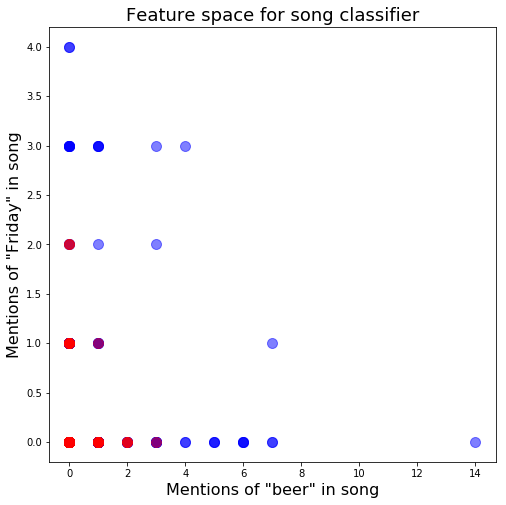

In [152]:
# View the artists in feature space
f1, f2 = 'beer','Friday'
x = np.array([sample[0][f1] for sample in test_set])
y = np.array([sample[0][f2] for sample in test_set])

mask_male   = np.array([sample[1]=='male'   for sample in test_set])
mask_female = np.array([sample[1]=='female' for sample in test_set])

print("Classifier accuracy: {}".format(acc))
fig, axs = plt.subplots(figsize=(8,8))
axs.plot(x[mask_male],   y[mask_male],   'bo', alpha=0.5, markersize=10)
axs.plot(x[mask_female], y[mask_female], 'ro', alpha=0.5, markersize=10)
axs.set_xlabel('Mentions of "{}" in song'.format(f1), fontsize=16);
axs.set_ylabel('Mentions of "{}" in song'.format(f2), fontsize=16);
axs.set_title("Feature space for song classifier", fontsize=18)
plt.show()

### Classify artists using Naive Bayes

In [155]:
# TODO: Clean these up. Combine them? Do I want to be using a DataFrame like I am?
def calcFreqForArtist(songs, terms):    
    if not isinstance(terms, list): terms = [terms]
    
    # Determine how many songs mention a given term
    song_count, term_count = len(songs), 0
    for song in songs:
        for term in terms:            
            if term.lower() in song['lyrics'].lower():
                term_count += 1
                break

    term_freq = round(term_count/float(song_count),5)    
    data = np.reshape([term_freq, term_count, song_count],(1,3))
    return pd.DataFrame(data, columns=['frequency','count','total'], index=[songs[0]['artist']])


In [156]:
# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_artists(artist):                        
    terms = ['beer','truck','girl','baby','Friday','Saturday','Love']

    percents = [float(100*calcFreqForArtist(artist['songs'], term)['frequency'].values) for term in terms]       
    return dict(zip(terms, percents))

# # Do this once? Or set random seed to be same each time?
labeled_artists = ([(artist, artist['gender']) for artist in artists])
random.shuffle(labeled_artists)

# Randomly split into train and test sets
n_train = round(0.6*len(labeled_artists))
train_set = apply_features(gender_features_artists, labeled_artists[:n_train])
test_set  = apply_features(gender_features_artists, labeled_artists[n_train:])
classifier = nltk.NaiveBayesClassifier.train(train_set)

acc = nltk.classify.accuracy(classifier, test_set)
print(acc)
classifier.show_most_informative_features(20)

0.6
Most Informative Features
                   truck = 0.0            female : male   =      6.1 : 1.0
                  Friday = 0.0            female : male   =      2.9 : 1.0
                    beer = 0.0            female : male   =      2.3 : 1.0
                Saturday = 0.0            female : male   =      1.9 : 1.0
                Saturday = 0.383          female : male   =      1.1 : 1.0
                    beer = 0.565          female : male   =      1.1 : 1.0
                    girl = 13.889000000000001 female : male   =      1.1 : 1.0


Classifier accuracy: 0.6


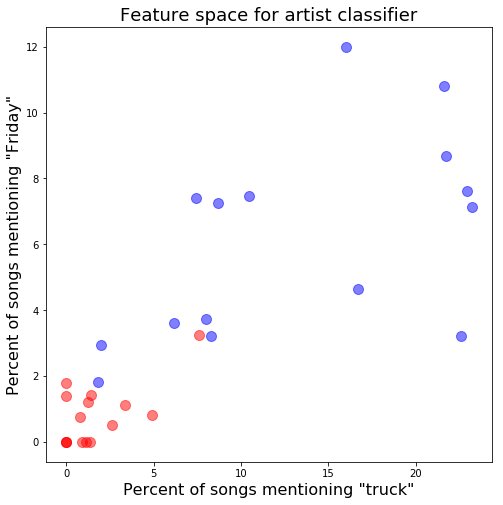

In [157]:
# View the artists in feature space
f1, f2 = 'truck','Friday'
x = np.array([sample[0][f1] for sample in test_set])
y = np.array([sample[0][f2] for sample in test_set])

mask_male   = np.array([sample[1]=='male'   for sample in test_set])
mask_female = np.array([sample[1]=='female' for sample in test_set])

print("Classifier accuracy: {}".format(acc))
fig, axs = plt.subplots(figsize=(8,8))
axs.plot(x[mask_male],   y[mask_male],   'bo', alpha=0.5, markersize=10)
axs.plot(x[mask_female], y[mask_female], 'ro', alpha=0.5, markersize=10)
axs.set_xlabel('Percent of songs mentioning "{}"'.format(f1), fontsize=16);
axs.set_ylabel('Percent of songs mentioning "{}"'.format(f2), fontsize=16);
axs.set_title("Feature space for artist classifier", fontsize=18)
plt.show()

### Word frequency distribution

In [5]:
# Tokenize the text
tokens = word_tokenize(all_lyrics)
text = nltk.Text(tokens)

# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english') + [',']

# Frequency distribution of word usage
fdist = nltk.FreqDist(word.lower() for word in text if word.lower() not in stopwords)

In [50]:
# Try to avoid stuff like " 's " and " 'm " that have slipped through
most_common = [w[0] for w in fdist.most_common(100) if len(re.subn("[,'\.]","",w[0])[0])>2]
most_common[:10]

['love', 'know', 'like', 'got', 'one', 'time', 'baby', 'never', 'way', 'get']

### scikit-learn
### [⇧](#Country-music-lyrics-analysis)

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
loo = LeaveOneOut()

#### Features for prediction of gender from song lyrics

In [144]:
# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_songs(lyrics):
    
    def countTerm(term):        
        return lyrics.lower().count(term.lower())
    
    def isPresent(term):
        return term.lower() in lyrics.lower()    
    
    terms = ['beer','truck','girl','baby','Friday','Saturday','Love']           
    counts = [countTerm(term) for term in terms]
    
#     binary_feats = ['beer','truck','girl','baby','Friday','Saturday','Love']    
    binary_feats = []
    terms = terms + binary_feats
    counts = counts + [isPresent(term) for term in terms[-len(binary_feats):]]
    
    return dict(zip(terms, counts))

# Do this once? Or set random seed to be same each time?
labeled_songs = ([(song['lyrics'], song['gender']) for song in all_songs])
features = apply_features(gender_features_songs, labeled_songs)
feature_names = list(features[0][0].keys())

# Extract features from song lyrics
data = np.zeros((len(features),len(features[0][0].values())))
labels = np.zeros(len(features))
for i, sample in enumerate(features):
    data[i,:] = list(sample[0].values())
    if sample[1] == 'male':
        labels[i] = 0
    else:
        labels[i] = 1
        
X, y = data, labels                    
DF = pd.DataFrame(data, columns=list(features[0][0].keys()))
DF = DF.assign(label=pd.Series(labels).values)
DF.head()

,beer,truck,girl,baby,Friday,Saturday,Love,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,11.0,0.0,0.0,3.0,1.0


#### Features for prediction of gender from artist discography

In [137]:
# TODO: Clean these up. Combine them? Do I want to be using a DataFrame like I am?
def calcFreqForArtist(songs, terms):    
    if not isinstance(terms, list): terms = [terms]
    
    # Determine how many songs mention a given term
    song_count, term_count = len(songs), 0
    for song in songs:
        for term in terms:            
            if term.lower() in song['lyrics'].lower():
                term_count += 1
                break

    term_freq = round(term_count/float(song_count),5)    
    data = np.reshape([term_freq, term_count, song_count],(1,3))
    return pd.DataFrame(data, columns=['frequency','count','total'], index=[songs[0]['artist']])

# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_artists(artist):                        
#     terms = ['beer','truck','girl','baby','Friday','Saturday','Love','back','want','need','get','got']
    terms = ['got','get','heart','like','love','back','little','yeah','night']

    percents = [float(100*calcFreqForArtist(artist['songs'], term)['frequency'].values) for term in terms]       
    return dict(zip(terms, percents))

labeled_artists = ([(artist, artist['gender']) for artist in artists])
artist_features = apply_features(gender_features_artists, labeled_artists)
feature_names = list(artist_features[0][0].keys())

# Extract features from artist lyrics
data = np.zeros((len(artist_features),len(artist_features[0][0].values())))
labels = np.zeros(len(artist_features))
for i, artist in enumerate(artist_features):
    data[i,:] = list(artist[0].values())
    if artist[1] == 'male':
        labels[i] = 0
    else:
        labels[i] = 1

X, y = data, labels            
DF = pd.DataFrame(data, columns=list(artist_features[0][0].keys()))
DF = DF.assign(label=pd.Series(labels).values)
DF.head()

,got,get,heart,like,love,back,little,yeah,night,label
0,27.517,24.832,39.597,53.691,51.007,24.832,11.409,6.711,30.872,1.0
1,34.959,43.902,37.398,40.650,66.667,30.894,25.203,30.894,48.780,1.0
2,27.692,43.846,41.538,44.615,62.308,22.308,20.000,30.000,36.154,1.0
3,29.091,40.909,38.636,40.455,59.091,24.091,17.727,26.364,26.818,1.0
4,36.036,44.144,41.441,46.847,54.054,34.234,21.622,14.414,44.144,1.0


### Random forest classifier for artist gender

In [140]:
# Random forest with n-fold cross validation
cv = 10
clf = RandomForestClassifier(n_estimators=50, max_features="log2")
scores = cross_validate(clf, X, y, scoring='precision_macro',cv=cv)
print("\nAverage accuracy across {} folds of CV: {:0.1f}".format(cv, 100*scores['test_score'].mean()))

# Random forest with n-fold cross validation
scores = cross_val_score(clf, X, y, cv=cv)
print("\nAverage accuracy across {} folds of CV: {:0.1f}".format(cv, 100*scores.mean()))


Average accuracy across 10 folds of CV: 87.0

Average accuracy across 10 folds of CV: 80.1


### Word clouds
### [⇧](#Country-music-lyrics-analysis)

In [117]:
from wordcloud import WordCloud

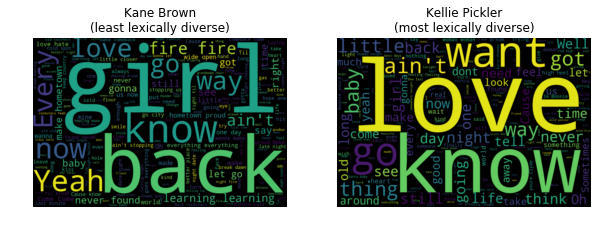

In [251]:
# Generate word clouds for the artists with the least and most lexical diversity
w,h = 1200, 800
wc_min = WordCloud(min_font_size=8,width=w,height=h).generate(" ".join([song['lyrics'] for song in artists[np.argmin(lexical_diversity)]['songs']]))
wc_max = WordCloud(min_font_size=8,width=w,height=h).generate(" ".join([song['lyrics'] for song in artists[np.argmax(lexical_diversity)]['songs']]))

artist_names = [artists[np.argmin(lexical_diversity)]['artist'] + "\n(least",
                artists[np.argmax(lexical_diversity)]['artist'] + "\n(most"]
fig, axs = plt.subplots(ncols=2, figsize=(10,10))
for ax,wc,name in zip(axs, [wc_min,wc_max], artist_names):
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("{name} lexically diverse)".format(name=name), fontsize=fs-4)

# fig.savefig("./figures/WordCloud_lexical_diversity",bbox_inches='tight',dpi=300)    
plt.show()

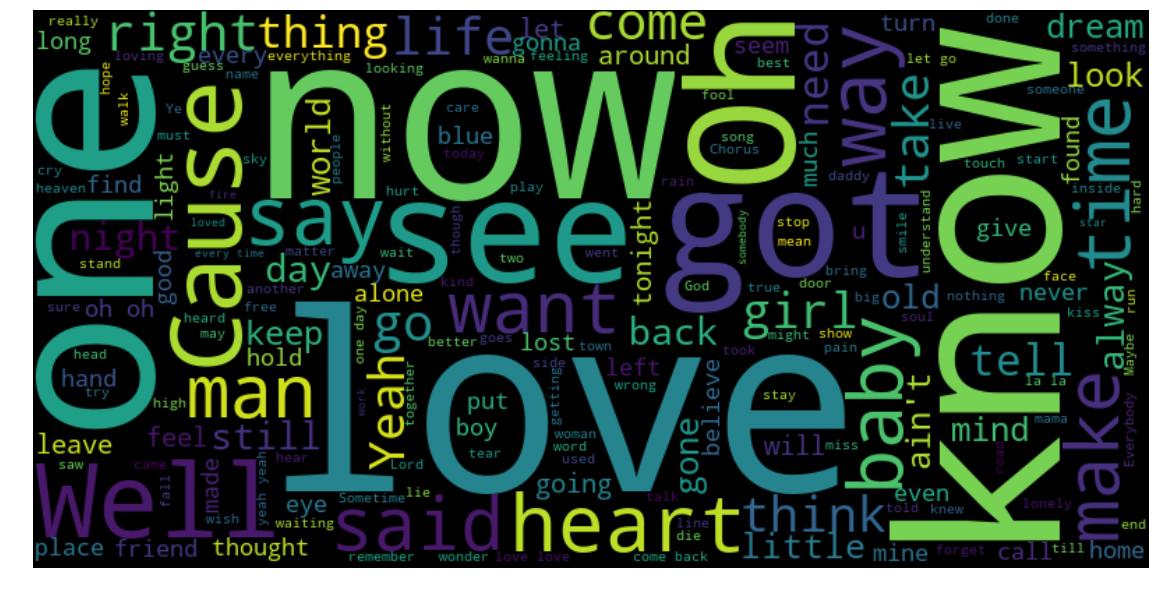

In [175]:
# Generate word clouds for all lyrics
wc1 = WordCloud(width=800,height=400).generate(all_lyrics)
plt.figure(figsize=(20,20))
plt.imshow(wc1, interpolation="bilinear")
plt.axis("off")
plt.show()

## Dimensionality-reduction
### [⇧](#Country-music-lyrics-analysis)

In [8]:
from collections import Counter

In [98]:
def countTermsAcrossArtist(artist, terms):
    stopwords = nltk.corpus.stopwords.words('english') + [',']
    
    artist_lyrics = " ".join([song['lyrics'] for song in artist['songs']])
    text = nltk.Text(word_tokenize(artist_lyrics.lower()))
    words = [word.lower() for word in text if word.lower() not in stopwords]
    
    # Populate the counter with zeros
    zero_counts = dict(zip(terms,[0]*len(terms)))    
    term_counts = {**zero_counts, **Counter([w for w in words if w in terms])} # merge dictionaries                
    
    # Scale by total number of words in artist's lyrics
    # A nice one liner (edited to remove square brackets)
    total_terms_counted = np.sum([val for val in term_counts.values()])
    term_counts.update((x, y/float(len(words))) for x, y in term_counts.items())
    
    return pd.Series(term_counts, name=artist['artist'])        

In [99]:
start = time.time()
artist_word_counts = pd.concat([countTermsAcrossArtist(artist, most_common) for artist in artists], axis=1).T
end = time.time()
print("Time elapsed: {} seconds.".format(end-start))
artist_word_counts.head()

Time elapsed: 34.54741406440735 seconds.


,'cause,alone,always,another,around,away,baby,back,better,blue,...,time,tonight,town,wan,want,way,well,world,would,yeah
Rosanne Cash,0.002510,0.001899,0.002510,0.000543,0.001967,0.004070,0.006783,0.005020,0.001153,0.002578,...,0.005359,0.002985,0.001153,0.000950,0.007055,0.004477,0.002171,0.004274,0.002239,0.001153
Sara Evans,0.004677,0.001242,0.002631,0.000877,0.002777,0.004312,0.008331,0.003654,0.001535,0.001023,...,0.005773,0.001973,0.001169,0.002850,0.005042,0.007600,0.003946,0.002265,0.004019,0.006431
Dolly Parton,0.001532,0.001456,0.004704,0.001042,0.002222,0.002682,0.003479,0.004689,0.002191,0.002360,...,0.005854,0.001640,0.000996,0.000582,0.004321,0.005026,0.003417,0.001732,0.003586,0.001134
Faith Hill,0.001265,0.000773,0.004990,0.002389,0.003655,0.003303,0.010612,0.003865,0.001757,0.000492,...,0.005411,0.001195,0.000843,0.002249,0.005833,0.013564,0.002530,0.004849,0.003022,0.008152
LeAnn Rimes,0.003132,0.001184,0.002559,0.000802,0.002101,0.003170,0.007027,0.003972,0.002979,0.002597,...,0.007218,0.001413,0.000229,0.004201,0.007066,0.004545,0.002559,0.004087,0.002979,0.006111


In [9]:
def calcFreqOfTerms(text, terms, song_name='WordCounts'):
                
    # Clean up text before counting terms
    stopwords = nltk.corpus.stopwords.words('english') + [',']
    text = nltk.Text(word_tokenize(text.lower()))
    words = [word.lower() for word in text if word.lower() not in stopwords]
    
    # Populate the counter with zeros
    zero_counts = dict(zip(terms,[0]*len(terms)))    
    term_counts = {**zero_counts, **Counter([w for w in words if w in terms])} # merge dictionaries                
    return pd.Series(term_counts, name=song_name)

In [35]:
# Count popular word occurences for each song
# This takes a minute or two to compuate
term_counts = pd.concat([calcFreqOfTerms(song['lyrics'], most_common, song['title']) for song in all_songs],axis=1).T
term_counts.head()

,'cause,...,alone,always,another,around,away,baby,back,better,...,time,tonight,town,wan,want,way,well,world,would,yeah
44 Stories,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
"50,000 Watts",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
500 Miles,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
A Feather's Not A Bird,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
Ain't No Money,0,0,0,0,0,3,0,11,0,0,...,0,0,0,0,0,2,0,0,0,0


In [163]:
# https://pandas.pydata.org/pandas-docs/stable/visualization.html

In [100]:
term_counts = artist_word_counts

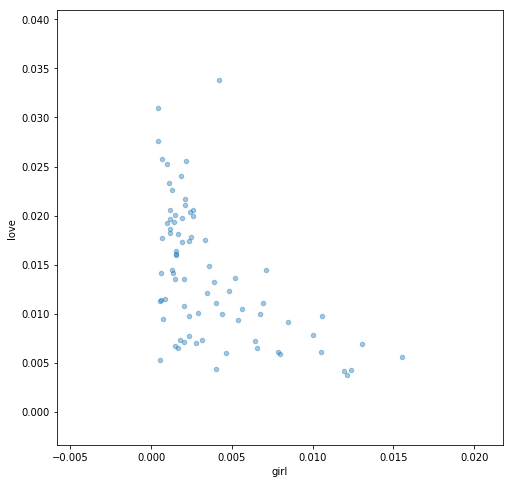

In [101]:
ax = term_counts.plot.scatter(x='girl', y='love', alpha=0.4, figsize=(8,8))

In [62]:
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

In [102]:
pca = PCA(n_components=10)
pca.fit(term_counts)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

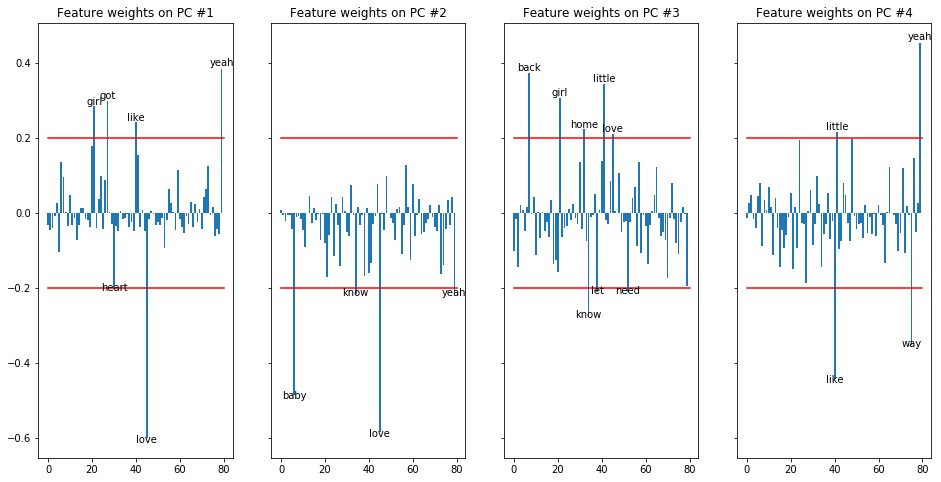

In [103]:
pcs = range(4)
thresholds = [0.2]*len(pcs)

fig, axs = plt.subplots(ncols=len(pcs), sharey=True, figsize=(16,8))

for ax, n_pc, thresh in zip(axs, pcs, thresholds):    
    # Features making up the PC
    mask_feats = (pca.components_[n_pc,:] < -thresh) + (pca.components_[n_pc,:] > thresh)
    feats = list(term_counts.columns[mask_feats])
    vals = (np.arange(pca.n_features_)[mask_feats], pca.components_[n_pc, mask_feats])

    # Plot the PC weights
    ax.bar(range(pca.n_features_), pca.components_[n_pc,:])
    ax.plot([0,pca.n_features_],  thresh*np.array([1,1]),'r-')
    ax.plot([0,pca.n_features_], -thresh*np.array([1,1]),'r-')
    ax.set_title("Feature weights on PC #{}".format(n_pc+1))
    for feat, x, y in zip(feats, vals[0],vals[1]):
        ax.annotate(feat,xy=(x,y*1.02),horizontalalignment='center')    
plt.show()

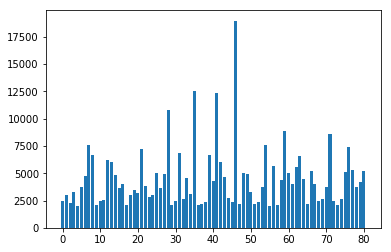

In [39]:
plt.bar(range(len(most_common)),term_counts.sum(axis=0))
plt.show()

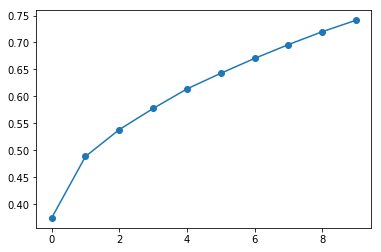

In [104]:
plt.plot(pca.explained_variance_ratio_.cumsum(),'o-')
plt.show()

In [81]:
X.shape

(78, 10)

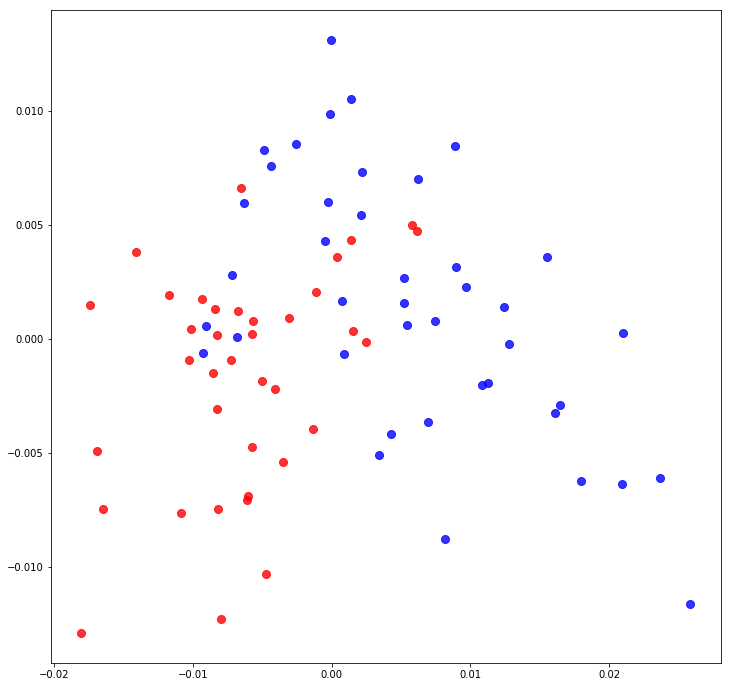

In [105]:
X = pca.transform(term_counts)

fig, ax = plt.subplots(figsize=(12,12))
pcs = [0,1]
ax.plot(X[mask_male,  pcs[0]], X[mask_male,   pcs[1]],'bo',alpha=0.8,markersize=8)
ax.plot(X[mask_female,pcs[0]], X[mask_female, pcs[1]],'ro',alpha=0.8,markersize=8)

# ax.set_aspect('equal')
# ax.set_xlim([-3,10])
# ax.set_ylim([-13,15])
plt.show()